# Load datasets and build one dataset by language

**Datasets:**
1. New round-2 completions (what we have labelled)
2. Old round-1 completions (what we have labelled)
3. Collected from telegram channels (we've collected channels for topics and downloaded posts)
4. Telegram provided labels from r-1 (true labels from round-1 for en and ru)


In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt
import logging
# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm, tqdm_notebook

from torchtext import data
import re
# custom path
os.chdir('../..')


In [2]:
from src.train.predict import load_test_file

## Data prep

In [3]:
COMPLETIONS_R2 = [
    'data/raw/r-2/completions/project-1-at-2021-04-20-16-16-72cac916.json',
    'data/raw/r-2/completions/project-1-current.json',
]

COMPLETIONS_R1 = [
    'data/raw/r-1/completions/2020-02-14_completions.json',
    'data/raw/r-1/completions/2020-02-14_active_completions.json',
]

TG_DOWNLOADS = {
        'META': 'data/raw/r-1/downloads/meta.csv',
        'POSTS': 'data/raw/r-1/downloads/posts.csv',
        'TOPICS': 'data/external/telegram_channels.csv'
    }

TG_TRUE_LABELS = [
    {
        'lang_code': 'en',
        'input': 'data/external/r-1/submission1489/category_en/input.txt',
        'output': 'data/external/r-1/submission1489/category_en/tg_output.txt'
    },
    {
        'lang_code': 'ru',
        'input': 'data/external/r-1/submission1489/category_ru/input.txt',
        'output': 'data/external/r-1/submission1489/category_ru/tg_output.txt'
    },
]

PRIMARY2SECONDARY = 3

In [29]:
def calc_topic_weights(primary, secondary):
    """ create a weight dict from topics """
    total = len(primary) * PRIMARY2SECONDARY + len(secondary)
    weights = {p: PRIMARY2SECONDARY / total for p in primary}
    weights.update({s: 1 / total for s in secondary})
    return weights


def get_topics(value):
    """ return a list of topics from one string topic or multiple from a dict """
    if isinstance(value, dict):
        topics = value['choices']
    else:
        topics = [value] if value != '' else []
    return topics


def raise_non_existent(file):
    raise Exception(f'{file} does not exist')


def load_labelled_data(files):
    if len(files) == 0:
        return pd.DataFrame()
    for f in files:
        if not os.path.exists(f):
            raise_non_existent(f)
    labelled_data = [pd.read_json(c,) for c in files]
    labelled_data = pd.concat(labelled_data)
    labelled_data['secondary'].fillna('', inplace=True)
    labelled_data['primary'] = labelled_data['primary'].apply(get_topics)
    labelled_data['secondary'] = labelled_data['secondary'].apply(get_topics)
    labelled_data['category'] = labelled_data.apply(lambda x: calc_topic_weights(x['primary'], x['secondary']), axis=1)
    labelled_data.drop([
        'primary','secondary', # encoded into `category`
        'subscribers', 'counters', # for now
        'annotator', 'annotation_id', 'title_display', 'description_display', 'recent_posts_display', # from new completions
        "predictions", "score", "posts", # old completions
    ], axis=1, inplace=True, errors='ignore')
    labelled_data.info()
    return labelled_data


def prepare_text(row):
    """ extract and merge all text from a channel """
    post_texts = '\n'.join([
        post.get('text', "") 
        if isinstance(post, dict) else post
        for post in row['recent_posts']
    ])
    merged = '\n'.join([row['title'], row['description'], post_texts])
    return merged

def show_lang_stats(data):
    lang_counts = data['lang_code'].value_counts()
    c = Counter()
    _ = [c.update(cat) for cat in data['category']]
    c = pd.DataFrame(c.most_common(len(c)), columns=['topic','score'])
    fig,axes = plt.subplots(1, 2, figsize=(15,7))
    sns.barplot(x=lang_counts, y=lang_counts.index, ax=axes[1]);
    sns.barplot(x=c['score'],y=c['topic'], ax=axes[0] );

### Load

#### New completions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 442 entries, 0 to 431
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         442 non-null    object
 1   description   442 non-null    object
 2   recent_posts  442 non-null    object
 3   lang_code     442 non-null    object
 4   id            442 non-null    int64 
 5   category      442 non-null    object
dtypes: int64(1), object(5)
memory usage: 24.2+ KB


,title,description,recent_posts,lang_code,id,category,subset
376,دانشگاه علوم پزشكی استان سمنان,دانشگاه علوم پزشكي استان سمنان\nداغ ترين اخبار...,"[{'type': 'photo', 'text': '✳️ رئیس دانشگاه عل...",fa,63,"{'Health & Medicine': 0.5, 'Politics & Inciden...",r-2_completions
313,Хадис ва хикматлар,Xadis va xikmatlar kanaliga xush kelibsiz! \nB...,"[{'type': 'text', 'text': 'https://youtu.be/Mn...",uz,142,"{'Motivation & Self-development': 0.5, 'Religi...",r-2_completions
264,꧁S͜͡o͜͡g͜͡'i͜͡n͜͡d͜͡i͜͡m͜͡ g͜͡u͜͡l͜͡i͜͡m͜͡꧂,꧁Assalomu alekum kanalimizga xush kelibsiz.꧂ \...,"[{'type': 'audio', 'text': 'Qo'shiqni topdim',...",uz,203,"{'Psychology & Relationships': 0.6, 'Movies': ...",r-2_completions
5,FX PIPSTER FREE GROUP 💰,,"[{'type': 'photo', 'text': 'Step index in prof...",en,494,{'Investments': 1.0},r-2_completions


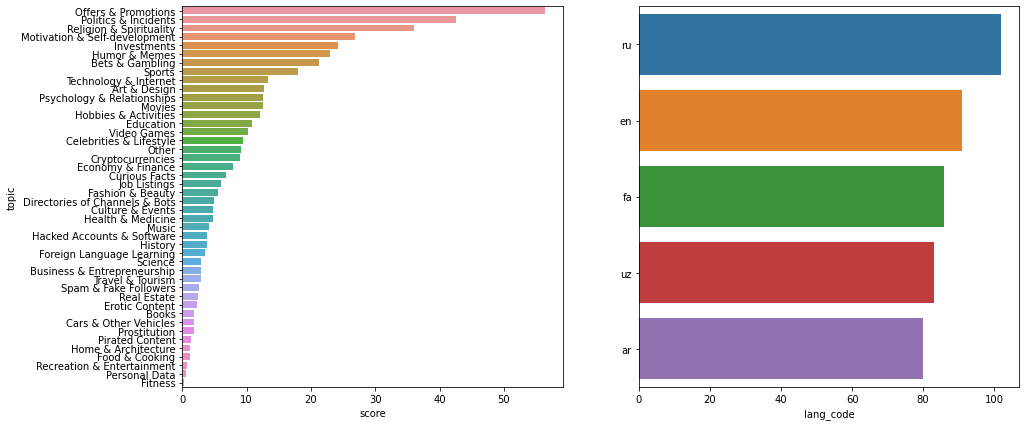

In [30]:
new_labels = load_labelled_data(COMPLETIONS_R2)
new_labels['subset'] = 'r-2_completions'

show_lang_stats(new_labels)

new_labels.sample(4)


#### Old completions

<class 'pandas.core.frame.DataFrame'>
Int64Index: 691 entries, 0 to 282
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   description   691 non-null    object
 1   lang_code     691 non-null    object
 2   recent_posts  691 non-null    object
 3   title         691 non-null    object
 4   id            691 non-null    int64 
 5   category      691 non-null    object
dtypes: int64(1), object(5)
memory usage: 37.8+ KB


,description,lang_code,recent_posts,title,id,category,subset
136,,ru,[#Ливерпуль_КристалПэлэс ⏰ 2-й Тайм 6:00\n5:7 ...,🔰Чемпионат Англии ( 4 x 4 )🔰,142,{'Sports': 1.0},r-1_completions
238,С нами зарабатывают!\n\nНаш Чат-бот: @Na_Domy_...,ru,[Ищу специалиста по Тильде. \n\nМагазин женско...,FREELANCE /// ВАКАНСИИ,384,{'Job Listings': 1.0},r-1_completions
28,Актуальные новости криптовалют - оставайтесь в...,ru,[​​Илон Маск: «я сторонник биткоина»\n\n«Сейча...,Криптовалюта📣,35,{'Cryptocurrencies': 1.0},r-1_completions


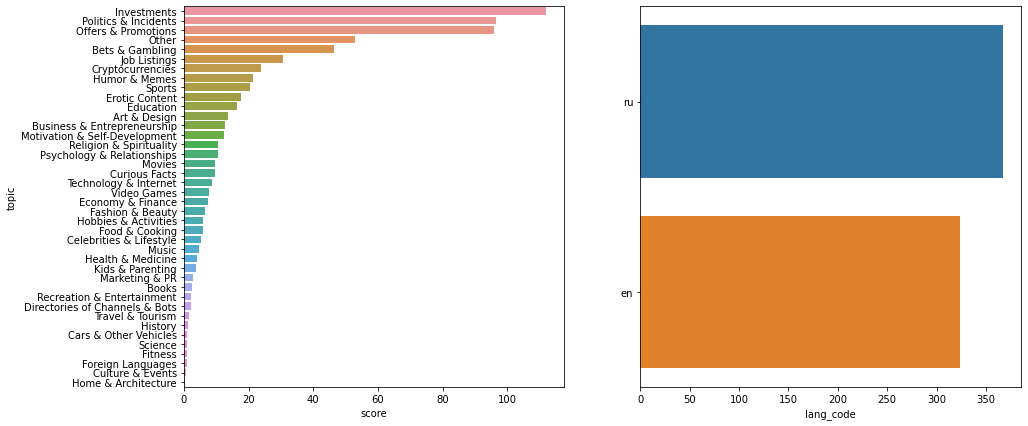

In [31]:
old_labels = load_labelled_data(COMPLETIONS_R1)
old_labels['subset'] = 'r-1_completions'


show_lang_stats(old_labels)

old_labels.sample(3)


#### Tg channel downloads

In [32]:
posts = pd.read_csv(TG_DOWNLOADS['POSTS'])
meta = pd.read_csv(TG_DOWNLOADS['META'])
topics = pd.read_csv(TG_DOWNLOADS['TOPICS'])

# clean
topics['topic [Secondary]'].fillna("", inplace=True)
posts['message'].fillna("", inplace=True)
meta['about'].fillna("", inplace=True)

# new cols
topics['username'] = topics['link'].apply(lambda x: x.split('/')[-1])
topics['lang_code'] = topics['language'].apply(lambda x: x.lower()[:2])

# rename
posts.rename({'channel':'username', 'message': 'recent_posts'}, axis=1, inplace=True)
meta.rename({'about':'description',}, axis=1, inplace=True)

# calculate topic weights
topics['primary'] = topics['topic [Primary]'].apply(lambda x: x.split(','))
topics['secondary'] = topics['topic [Secondary]'].apply(lambda x: x.split(',') if x != '' else [])
topics['category'] = topics.apply(lambda x: calc_topic_weights(x['primary'], x['secondary']), 
                               axis=1)

# group recent posts
posts = posts.groupby('username', as_index=False).agg({'recent_posts': lambda row: list(x for x in row if x != '')})


# merge
tg_downloads = topics[['username','lang_code','category']]\
            .merge(meta, on=['username'])\
            .merge(posts, on='username')
tg_downloads['subset'] = 'tg_downloads'


del tg_downloads['username']

<class 'pandas.core.frame.DataFrame'>
Int64Index: 531 entries, 0 to 530
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   lang_code     531 non-null    object
 1   category      531 non-null    object
 2   title         531 non-null    object
 3   description   531 non-null    object
 4   recent_posts  531 non-null    object
 5   subset        531 non-null    object
dtypes: object(6)
memory usage: 29.0+ KB


,lang_code,category,title,description,recent_posts,subset
528,ru,"{'Humor & Memes': 0.5, ' Technology & Internet...",THINGS PROGRAMMERS DO,Most people who aren’t programmers assume that...,"[Спецификации vs продакшен, Начните осваивать ...",tg_downloads
364,en,"{'Business & Entrepreneurship': 0.5, ' Offers ...",Entrepreneur'sHome,Make money online...with you skills,[The second bag is sold on 1688 for approx N80...,tg_downloads
304,en,"{'Foreign Languages': 0.75, 'Movies': 0.25}",Learn Arabic with videos👍,,"[https://youtu.be/k3QzBIpne1k, https://youtu.b...",tg_downloads
255,en,{'Travel & Tourism': 1.0},"NewWayExplorer - Travel, Trips, Food, Explore",#NewWayExplorer - Travel | Trips | Food | Expl...,"[https://youtu.be/MBN3v-Hl3FA, NewWayExplorer ...",tg_downloads


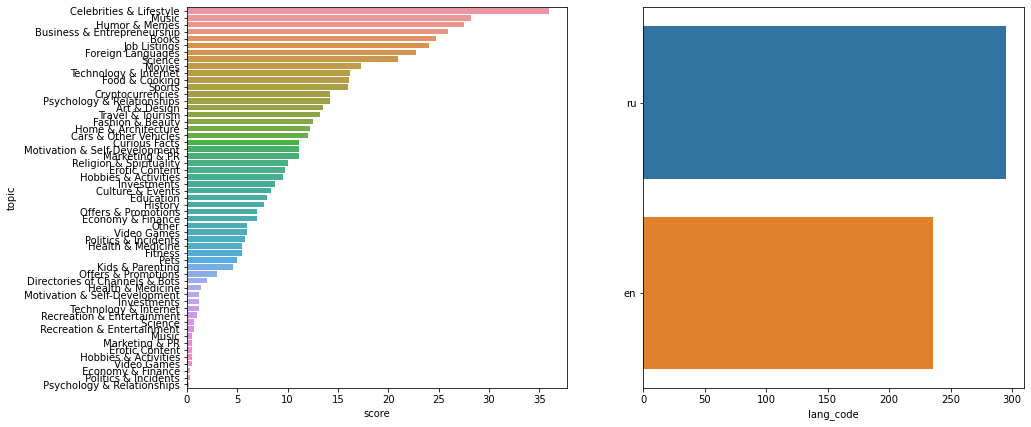

In [33]:
tg_downloads.info()

show_lang_stats(tg_downloads)

tg_downloads.sample(4)


#### Tg true labels

In [34]:
def update_dict(src_dict,dest_dict):
    src_dict.update(dest_dict)
    return src_dict

In [35]:
tg_true = []

for files in TG_TRUE_LABELS:
    inp = load_test_file(files['input'])
    out = load_test_file(files['output'])
    tg_true.extend([update_dict(i, o) for i,o in zip(inp, out)])

    
tg_true = pd.DataFrame(tg_true)

tg_true['subset'] = 'tg_true'

Loaded 14775 rows
Loaded 14775 rows
Loaded 16726 rows
Loaded 16726 rows


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31501 entries, 0 to 31500
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   title         31501 non-null  object
 1   description   31501 non-null  object
 2   recent_posts  31501 non-null  object
 3   lang_code     31501 non-null  object
 4   category      31501 non-null  object
 5   subset        31501 non-null  object
dtypes: object(6)
memory usage: 1.4+ MB


,title,description,recent_posts,lang_code,category,subset
11885,Nostra pro (Perfect prediction),Cricket 🏏🏏 Expert\nTable Tennis 🎾 Expert\nFoot...,"[All the best, I m going with this Team 👍, I h...",en,{'Bets & Gambling': 1},tg_true
21420,ᴄhᴀrliᴄrush | hᴇlᴩ,"꒰ᴨᴏʍᴏщь ϶диᴛᴏᴩᴀʍ!!\nʍнᴏᴦᴏ бᴇᴄᴨᴧᴀᴛных ʙᴇᴧᴏᴄиᴛи,...","[🙇🏻‍♀️||с кем делать такие авы?, 🙇🏻‍♀️||я завт...",ru,"{'Technology & Internet': 0.14285714285714, 'A...",tg_true
26461,Москва Протестует ⚔️,⚡️Москва Протестует — единственный канал в Рос...,[Столичные коммунальщики не боятся не только н...,ru,{'Politics & Incidents': 1},tg_true


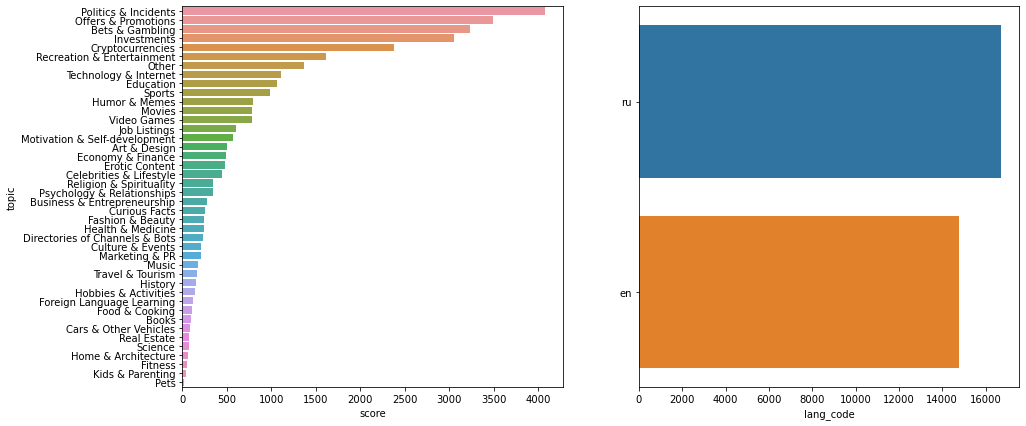

In [36]:
tg_true.info()

show_lang_stats(tg_true)

tg_true.sample(3)

## Combine and save

### concat

In [37]:
comb = pd.concat([
    new_labels,
    old_labels,
    tg_downloads,
    tg_true,

], axis=0)
comb.shape

(33165, 7)

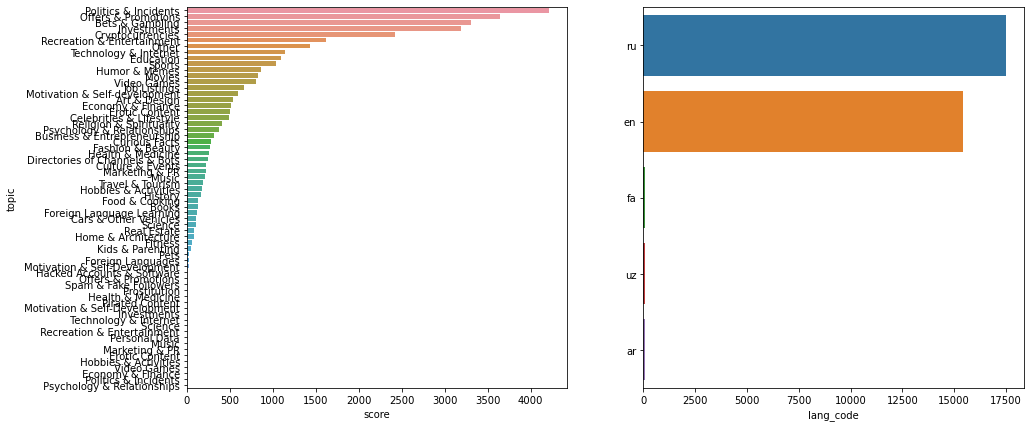

In [38]:
show_lang_stats(comb)

In [39]:
comb['subset'].value_counts()

tg_true            31501
r-1_completions      691
tg_downloads         531
r-2_completions      442
Name: subset, dtype: int64

### get raw texts

In [40]:
comb['text'] = comb.apply(prepare_text, axis=1)

### Save

In [41]:
comb.to_csv('data/interim/train_data.csv', index=False)